In [1]:
!nvidia-smi

Thu Nov  2 03:08:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
## Creating helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2023-11-02 03:08:22--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-11-02 03:08:22 (109 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir



## 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training
data

In [4]:

# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2023-11-02 03:08:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 2607:f8b0:4023:c0d::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  72.0MB/s    in 18s     

2023-11-02 03:08:46 (85.1 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# How many images/classes are there?
walk_through_dir("/content/101_food_classes_10_percent")

There are 2 directories and 0 images in '/content/101_food_classes_10_percent'.
There are 101 directories and 0 images in '/content/101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '/content/101_food_classes_10_percent/train/mussels'.
There are 0 directories and 75 images in '/content/101_food_classes_10_percent/train/foie_gras'.
There are 0 directories and 75 images in '/content/101_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '/content/101_food_classes_10_percent/train/clam_chowder'.
There are 0 directories and 75 images in '/content/101_food_classes_10_percent/train/spaghetti_carbonara'.
There are 0 directories and 75 images in '/content/101_food_classes_10_percent/train/falafel'.
There are 0 directories and 75 images in '/content/101_food_classes_10_percent/train/strawberry_shortcake'.
There are 0 directories and 75 images in '/content/101_food_classes_10_percent/train/panna_cotta'.
There are 0 directories and 75 ima

In [6]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    image_size=IMG_SIZE
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    shuffle=False
)



Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we are going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layers
* Build a headless (no top layers) Functional EficcientNetB0 backboned-model
* Compile our model
* Feature extract 5 full passes

In [7]:
#  Create model checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_best_only=True,
    monitor="val_accuracy",
    save_weights_only=True
    )

In [8]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Sequential


# Set up data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
     preprocessing.RandomWidth(0.2),
     preprocessing.RandomZoom(0.2),
], name="data_augmentation")




In [9]:
# set up base model

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture
inputs= layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False) # Put the base model in inference mode
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(test_data.class_names), activation='softmax', name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pool_layer (Glo  (None, 1280)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [11]:
# Compile model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)


In [12]:
# Fit model

history_10_percent = model.fit(
    train_data_all_10_percent,
    epochs=3,
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)), # Valide only on 15 off test data
    callbacks=[checkpoint_callback]
    )

Epoch 1/3
237/237 [==============================] - 123s 453ms/step - loss: 0.0857 - accuracy: 0.1485 - val_loss: 0.0484 - val_accuracy: 0.3329
Epoch 2/3
237/237 [==============================] - 79s 334ms/step - loss: 0.0459 - accuracy: 0.4042 - val_loss: 0.0407 - val_accuracy: 0.4619
Epoch 3/3
237/237 [==============================] - 68s 285ms/step - loss: 0.0386 - accuracy: 0.4949 - val_loss: 0.0375 - val_accuracy: 0.5045


In [13]:
# Evaluate on the wole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 62s 78ms/step - loss: 0.0377 - accuracy: 0.5332


[0.03774835541844368, 0.5332277417182922]

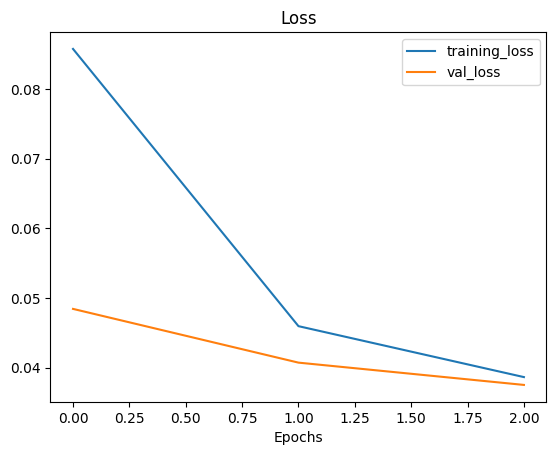

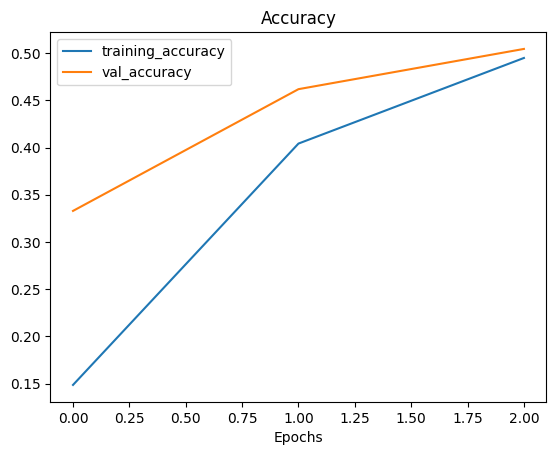

In [14]:
plot_loss_curves(history_10_percent)

## Fine tuning

In [15]:
# Unfreze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False


In [16]:
# Recompile model with lower rate since we are fine tuning
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

In [17]:
# What layer in the model are trainable
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [18]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [19]:
# Fine tune for 5 more epochs
fine_tune_epochs = 5 # Model has already 5 epochs (feature extration)

history_all_classes_10_percent_fine_tune = model.fit(
   train_data_all_10_percent,
    epochs=fine_tune_epochs,
   initial_epoch=history_10_percent.epoch[-1],
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)), # Valide only on 15 off test data
    callbacks=[checkpoint_callback]

)

Epoch 3/5
237/237 [==============================] - 80s 286ms/step - loss: 0.0302 - accuracy: 0.5719 - val_loss: 0.0305 - val_accuracy: 0.5119
Epoch 4/5
237/237 [==============================] - 61s 257ms/step - loss: 0.0261 - accuracy: 0.5913 - val_loss: 0.0286 - val_accuracy: 0.5278
Epoch 5/5
237/237 [==============================] - 59s 249ms/step - loss: 0.0243 - accuracy: 0.6153 - val_loss: 0.0277 - val_accuracy: 0.5336


In [20]:
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 63s 80ms/step - loss: 0.0252 - accuracy: 0.5820


[0.025222433730959892, 0.5819801688194275]

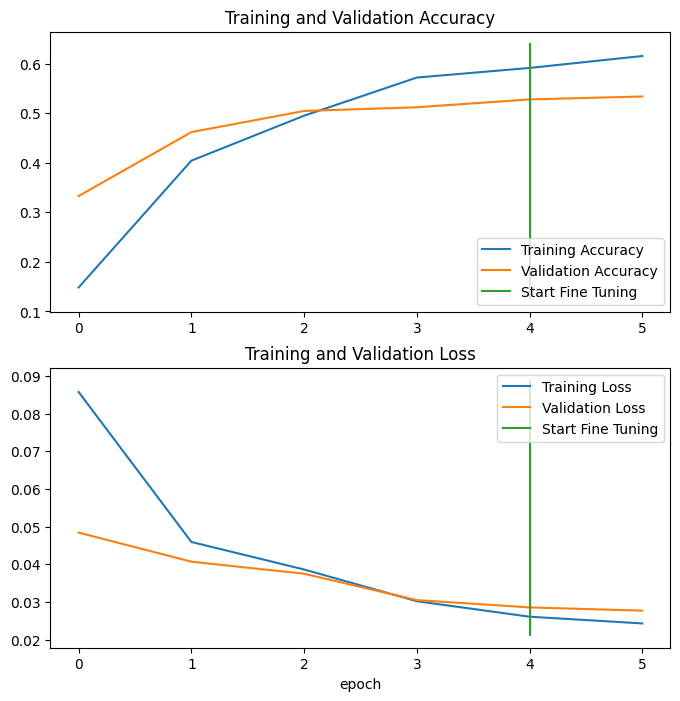

In [21]:
# Compare histories of feature extraction with fine tunning
compare_historys(history_10_percent, history_all_classes_10_percent_fine_tune, 5)

## Saving and loading model


In [22]:
# Save our fine tuning model

In [23]:
model.save("/content/drive/MyDrive/TF Models/01_f00d_classes_10_percent")

In [24]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/TF Models/01_f00d_classes_10_percent")

In [25]:
# Evalaute loaded model and compare perfomance
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 64s 79ms/step - loss: 0.0252 - accuracy: 0.5820


[0.025222433730959892, 0.5819801688194275]

In [26]:
all_classes_10_percent_fine_tune_results

[0.025222433730959892, 0.5819801688194275]

In [27]:
loaded_model_results == all_classes_10_percent_fine_tune_results

True

## Evaluation the performance of the big model across all data

In [28]:
import tensorflow as tf

# Download pre-trained model from Google Storage (like a cooking show, I trained this model earlier, so the results may be different than above)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
unzip_data(saved_model_path)

# Note: loading a model will output a lot of 'WARNINGS', these can be ignored: https://www.tensorflow.org/tutorials/keras/save_and_load#save_checkpoints_during_training
# There's also a thread on GitHub trying to fix these warnings: https://github.com/tensorflow/tensorflow/issues/40166
# model = tf.keras.models.load_model("drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model/") # path to drive model
model = tf.keras.models.load_model(saved_model_path.split(".")[0]) # don't include ".zip" in loaded model path


--2023-11-02 03:23:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.141.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   111MB/s    in 0.4s    

2023-11-02 03:23:17 (111 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [29]:

# Check to see if loaded model is a trained model
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy

790/790 [==============================] - 63s 78ms/step - loss: 1.8027 - accuracy: 0.6078


(1.8027206659317017, 0.6077623963356018)

## Making predictions with trained model

In [30]:
preds_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 67s 81ms/step


In [31]:
# How many predictions are there?
len(preds_probs)

25250

In [32]:
preds_probs.shape

(25250, 101)

In [33]:
# Lets see what the first 10 predictions look like
preds_probs[:10]

array([[5.9542079e-02, 3.5742114e-06, 4.1377071e-02, ..., 1.4138705e-09,
        8.3530424e-05, 3.0897493e-03],
       [9.6401680e-01, 1.3753272e-09, 8.4780494e-04, ..., 5.4286946e-05,
        7.8362065e-12, 9.8466024e-10],
       [9.5925868e-01, 3.2533771e-05, 1.4867012e-03, ..., 7.1891407e-07,
        5.4397475e-07, 4.0276118e-05],
       ...,
       [4.7313249e-01, 1.2931206e-07, 1.4805582e-03, ..., 5.9750117e-04,
        6.6969209e-05, 2.3469403e-05],
       [4.4571843e-02, 4.7265397e-07, 1.2258503e-01, ..., 6.3498451e-06,
        7.5318876e-06, 3.6778769e-03],
       [7.2438902e-01, 1.9249717e-09, 5.2310897e-05, ..., 1.2291410e-03,
        1.5792732e-09, 9.6395481e-05]], dtype=float32)

In [34]:
preds_probs[0], sum(preds_probs[0])

(array([5.9542079e-02, 3.5742114e-06, 4.1377071e-02, 1.0660534e-09,
        8.1614422e-09, 8.6639478e-09, 8.0927344e-07, 8.5652732e-07,
        1.9859108e-05, 8.0977674e-07, 3.1727800e-09, 9.8673911e-07,
        2.8532281e-04, 7.8048890e-10, 7.4230117e-04, 3.8916227e-05,
        6.4740480e-06, 2.4977348e-06, 3.7891161e-05, 2.0678284e-07,
        1.5538406e-05, 8.1507324e-07, 2.6230616e-06, 2.0010684e-07,
        8.3827518e-07, 5.4215925e-06, 3.7390960e-06, 1.3150530e-08,
        2.7761441e-03, 2.8051916e-05, 6.8562017e-10, 2.5574853e-05,
        1.6688927e-04, 7.6406986e-10, 4.0452811e-04, 1.3150683e-08,
        1.7957391e-06, 1.4448174e-06, 2.3062844e-02, 8.2466693e-07,
        8.5365679e-07, 1.7138593e-06, 7.0525425e-06, 1.8402130e-08,
        2.8553373e-07, 7.9483443e-06, 2.0681530e-06, 1.8525149e-07,
        3.3619703e-08, 3.1522504e-04, 1.0410941e-05, 8.5448431e-07,
        8.4741855e-01, 1.0555424e-05, 4.4094787e-07, 3.7404032e-05,
        3.5306188e-05, 3.2488941e-05, 6.7314730e

Our model outputs a prediction probability array

In [35]:
# We get one prediction per class
print(f"Number of prediction probs for sample 0: {len(preds_probs[0])}")
print(f"What predictions prob sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highes predicted prob by the model sample 0: {preds_probs[0].argmax()}")

Number of prediction probs for sample 0: 101
What predictions prob sample 0 looks like:
 [5.9542079e-02 3.5742114e-06 4.1377071e-02 1.0660534e-09 8.1614422e-09
 8.6639478e-09 8.0927344e-07 8.5652732e-07 1.9859108e-05 8.0977674e-07
 3.1727800e-09 9.8673911e-07 2.8532281e-04 7.8048890e-10 7.4230117e-04
 3.8916227e-05 6.4740480e-06 2.4977348e-06 3.7891161e-05 2.0678284e-07
 1.5538406e-05 8.1507324e-07 2.6230616e-06 2.0010684e-07 8.3827518e-07
 5.4215925e-06 3.7390960e-06 1.3150530e-08 2.7761441e-03 2.8051916e-05
 6.8562017e-10 2.5574853e-05 1.6688927e-04 7.6406986e-10 4.0452811e-04
 1.3150683e-08 1.7957391e-06 1.4448174e-06 2.3062844e-02 8.2466693e-07
 8.5365679e-07 1.7138593e-06 7.0525425e-06 1.8402130e-08 2.8553373e-07
 7.9483443e-06 2.0681530e-06 1.8525149e-07 3.3619703e-08 3.1522504e-04
 1.0410941e-05 8.5448431e-07 8.4741855e-01 1.0555424e-05 4.4094787e-07
 3.7404032e-05 3.5306188e-05 3.2488941e-05 6.7314730e-05 1.2852589e-08
 2.6219654e-10 1.0318089e-05 8.5743537e-05 1.0569885e-06 2.

In [36]:
test_data.class_names[52]

'gyoza'

In [37]:
pred_classes = preds_probs.argmax(axis=1)

# How they look
pred_classes

array([ 52,   0,   0, ..., 100,  94, 100])

In [38]:
len(pred_classes)

25250

Now we ve got a predictions array of all of our models predictions, to evaluate them, we need to compare to the original test dataset labels

In [39]:
# To get our test labbels we need to unrvel our test_data
y_labels = []

for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # Currently test labels look like: [0, 0, 0, 1, 0 ...], we want the index value where 1 occurs



In [40]:
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [41]:
# How many y_labels are there?
len(y_labels)

25250

## Evaluating our models predictions

One way to check models predictions array is in the same order as our test labels array is to find the accuracy score

In [42]:
loaded_accuracy

0.6077623963356018

In [43]:
# Lets try scilit learns accuracy score function and see that it comes up with
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(
    y_true=y_labels,
    y_pred=pred_classes
)

sklearn_accuracy

0.6077623762376237

In [44]:
# Does this metric come close to our models evaluate results
import numpy as np
np.isclose(loaded_accuracy,sklearn_accuracy)

True

## Lets get visual:  Making confusion matrix

In [45]:
class_names = test_data.class_names


We need to make some changes in the confusion matrix function

In [46]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [47]:
#from helper_functions import make_confusion_matrix
make_confusion_matrix(
    y_true=y_labels,
    y_pred=pred_classes,
    classes=class_names,
    figsize=(100, 100),
    text_size=20,
    savefig=True
)

In [48]:
from sklearn.metrics import classification_report
print(classification_report(
    y_true=y_labels,
    y_pred=pred_classes
))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [49]:
# Get a dictionary of the classifcation report
classification_report = classification_report(
    y_true=y_labels,
    y_pred=pred_classes,
    output_dict = True
)

classification_report

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

Lets plot all of our classes F1-Score

In [50]:
# Create empty dictionary
class_f1_scores = {}

# Loop over classification report dict items
for k, v in classification_report.items():
  if k == 'accuracy': # steop once we get to accuracy key
    break
  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [51]:
# Turn f1 scores intoa datagrame for visualization
import pandas as pd
f1_scores = pd.DataFrame({
    'class_names': list(class_f1_scores.keys()),
    'f1-score': list(class_f1_scores.values())
}).sort_values(by=['f1-score'], ascending=False)
f1_scores

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
..                  ...       ...
56     huevos_rancheros  0.339833
22     chocolate_mousse  0.329159
77            pork_chop  0.308756
39            foie_gras  0.297491
0             apple_pie  0.240566

[101 rows x 2 columns]

In [52]:
f1_scores

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
..                  ...       ...
56     huevos_rancheros  0.339833
22     chocolate_mousse  0.329159
77            pork_chop  0.308756
39            foie_gras  0.297491
0             apple_pie  0.240566

[101 rows x 2 columns]

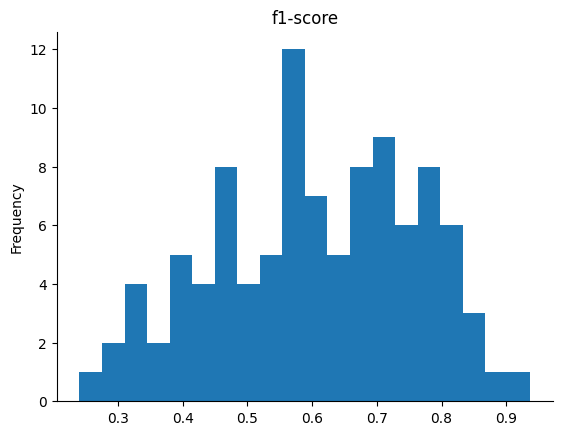

In [53]:
from matplotlib import pyplot as plt
f1_scores['f1-score'].plot(kind='hist', bins=20, title='f1-score')
plt.gca().spines[['top', 'right',]].set_visible(False)

## PLot f1 scores grouped by class name

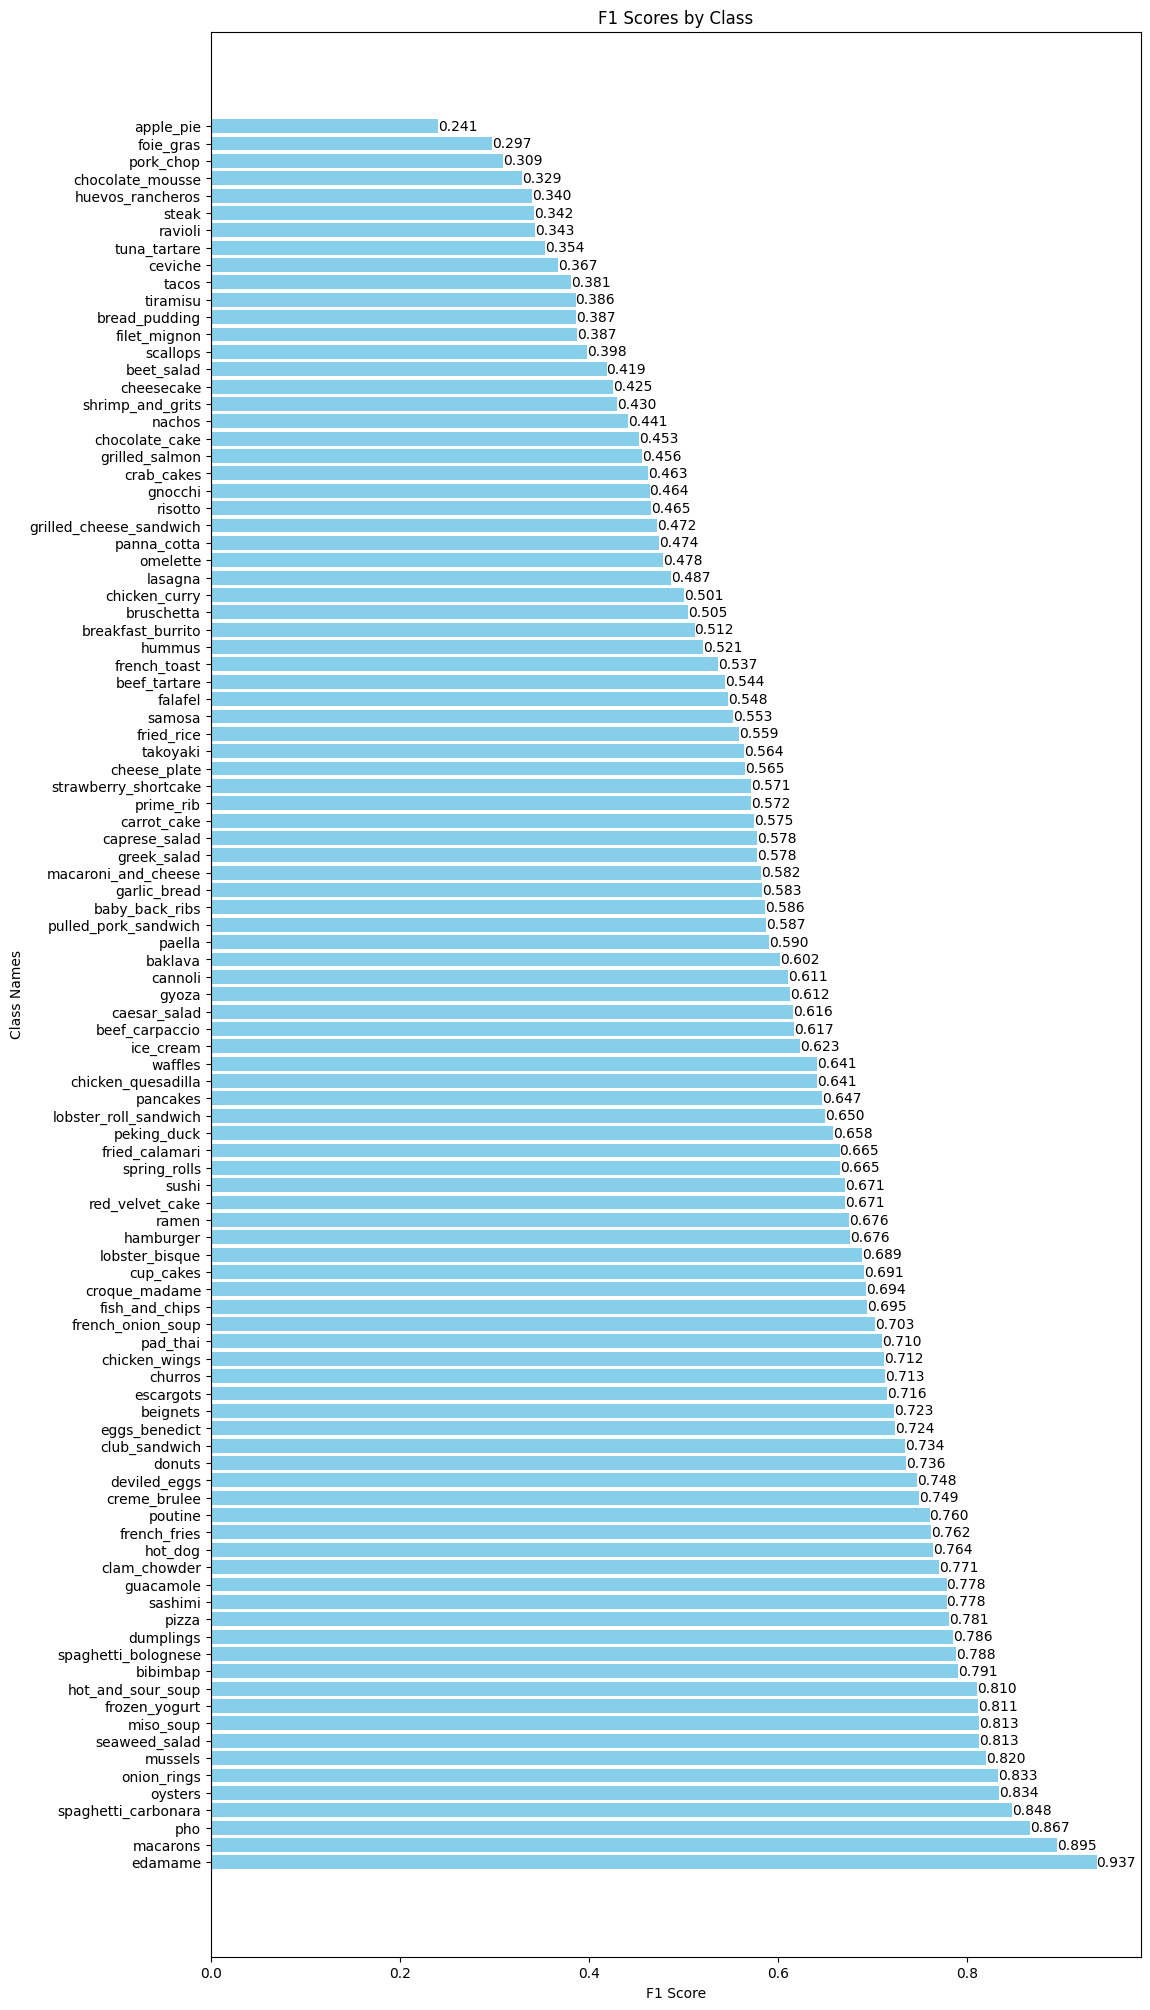

In [54]:
# Convert 'f1-score' to numeric
f1_scores['f1-score'] = pd.to_numeric(f1_scores['f1-score'])

# Adjust the figsize
plt.figure(figsize=(12, 25))  # Set the figure size (width=8 inches, height=6 inches)

# Plot the 'f1-score' column as a horizontal bar chart
bars = plt.barh(f1_scores['class_names'], f1_scores['f1-score'], color='skyblue')
plt.xlabel('F1 Score')
plt.ylabel('Class Names')
plt.title('F1 Scores by Class')

for bar, f1_score in zip(bars, f1_scores['f1-score']):
  plt.text(f1_score, bar.get_y() + bar.get_height()/ 2, f'{f1_score:.3f}', ha='left', va='center', fontsize=10)

plt.show()

## Visualizing predictions on custom images

In [55]:
# Createa fucntion to laod an prepare image

def load_and_prep_image(filename, img_shape=224, scale=True):

  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale? Yes/ No
  if scale:
    # Rescale the image
    return img/255.
  else:
    return img


Now we've got a function to load and prepare out images, lets not write some to visualize images

101_food_classes_10_percent/test/donuts/700534.jpg
1/1 [==============================] - 0s 31ms/step
[[3.03183292e-08 2.38413438e-11 2.03408685e-08 4.49599469e-09
  1.95280614e-09 1.20573412e-11 7.66853636e-10 2.79619574e-11
  4.66648897e-09 5.44397665e-08 2.84165912e-06 2.50585469e-10
  5.53390601e-06 9.57134853e-06 4.96072244e-06 1.01988883e-06
  2.93544975e-08 1.54510997e-06 9.11714881e-09 1.78441368e-07
  1.67734822e-08 2.89101365e-07 5.55475950e-08 8.10850764e-08
  1.37117535e-08 4.91212626e-09 8.80264679e-07 2.87116719e-11
  9.45046930e-10 4.02589329e-02 2.78089152e-09 6.90960705e-01
  4.76700813e-03 3.07972825e-09 9.69467919e-08 3.00195673e-08
  4.20668265e-08 4.29296841e-11 7.02242171e-12 6.16741241e-11
  2.21816054e-09 3.18758217e-14 2.23174784e-10 1.85928287e-10
  1.79647175e-09 1.76975419e-07 8.37207637e-10 1.04301134e-09
  1.29185471e-08 2.90127122e-09 8.03527058e-08 4.94525254e-10
  1.03306309e-04 2.56909487e-07 2.49359040e-11 8.65021357e-05
  8.38482990e-08 1.44045018e-

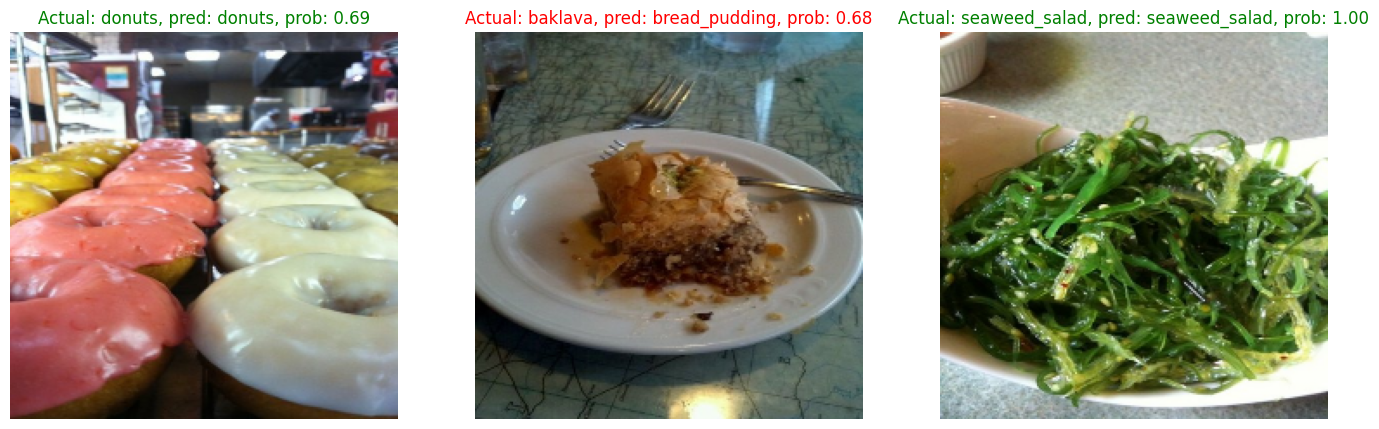

In [58]:
# Make preds on a series of random images

import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random from a randcom class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename
  print(filepath)

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]
  print(pred_prob)
  print(pred_class)

  # Plot the image
  plt.subplot(1,3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # If predicted class matches truth classes
    title_color = 'g'
  else:
    title_color = "r"

  plt.title(f"Actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False)